## Analysis on streetlight distribution

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import folium
from shapely.geometry import Point
import utm
import pyproj
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
m = folium.Map(location=[42.3601, -71.0589], zoom_start=12)
# Read the police districts shapefile
police_districts = gpd.read_file('locationsshapefiles/Police_Districts/Police_Districts.shp')
selected_districts = ['C11', 'B2', 'B3']

# Create a GeoJSON layer for the police districts
folium.GeoJson(police_districts, style_function=lambda x: {'color': 'green' if x['properties']['DISTRICT'] in selected_districts else 'blue', 'weight': 2}).add_to(m)

In [4]:
streetlights = pd.read_csv('locationscsv/streetlight-locations.csv')
streetlights

,the_geom,OBJECTID,TYPE,Lat,Long
0,POINT (-71.0760443807948 42.35315925057316),1,LIGHT,42.353159,-71.076044
1,POINT (-71.07538171240694 42.353347768071195),2,LIGHT,42.353348,-71.075382
2,POINT (-71.07477488057383 42.35352052068278),3,LIGHT,42.353521,-71.074775
3,POINT (-71.07440373484715 42.3535558201314),4,LIGHT,42.353556,-71.074404
4,POINT (-71.07362079549182 42.35381056415504),5,LIGHT,42.353811,-71.073621
...,...,...,...,...,...
74060,POINT (-71.08033155733365 42.33491750082423),74061,LIGHT,42.334918,-71.080332
74061,POINT (-71.07976771888413 42.334734407302314),74062,LIGHT,42.334734,-71.079768
74062,POINT (-71.10732775577004 42.30126459583881),74063,LIGHT,42.301265,-71.107328
74063,POINT (-71.10744921600617 42.30134123649143),74064,LIGHT,42.301341,-71.107449


In [5]:
streetlight = gpd.GeoDataFrame(
    streetlights, 
    geometry=gpd.points_from_xy(streetlights.Long, streetlights.Lat)
)
lights_by_district = gpd.sjoin(streetlight, police_districts, op='within')

lights_count = lights_by_district.groupby('DISTRICT')['OBJECTID_left'].count()
lights_count

DISTRICT
A1     7960
A15    4189
A7     4738
B2     9924
B3     4500
C11    6689
C6     8365
D14    5591
D4     9508
E13    5021
E18    2161
E5     3872
Name: OBJECTID_left, dtype: int64

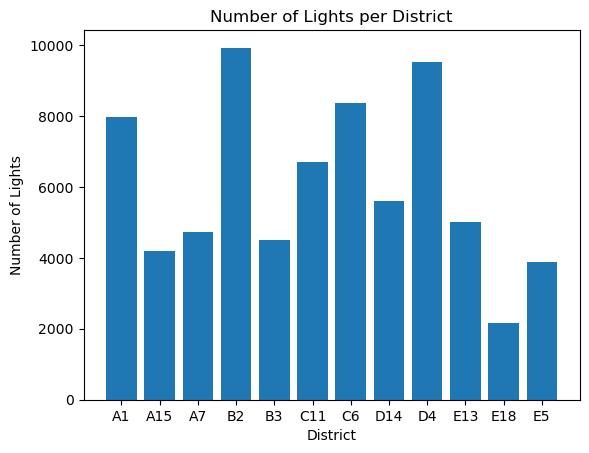

In [6]:
districts = lights_count.index
counts = lights_count.values

plt.bar(districts, counts)
plt.xlabel('District')
plt.ylabel('Number of Lights')
plt.title('Number of Lights per District')

plt.show()

In [7]:
police_districts['area_sqm'] = police_districts['geometry'].to_crs(epsg=3857).area

police_districts = police_districts.set_index('DISTRICT')  
police_districts['streetlights_count'] = lights_count
police_districts['streetlights_density'] = police_districts['streetlights_count'] / police_districts['area_sqm']

police_districts = police_districts.reset_index()
police_districts

,DISTRICT,OBJECTID,ID,BPDGIS_GIS,DISTRICT_,DISTRICT__,ShapeSTAre,ShapeSTLen,geometry,area_sqm,streetlights_count,streetlights_density
0,A15,1,A15,A,15,15,3.798284e+07,57556.859964,"MULTIPOLYGON (((-71.07416 42.39051, -71.07415 ...",6.471169e+06,4189,0.000647
1,A7,2,A7,A,7,07,1.401151e+08,138468.216080,"MULTIPOLYGON (((-70.99644 42.39557, -70.99644 ...",2.386551e+07,4738,0.000199
2,A1,3,A1,A,1,01,4.445582e+07,49080.786370,"POLYGON ((-71.05200 42.36884, -71.05169 42.368...",7.568905e+06,7960,0.001052
3,C6,4,C6,C,6,06,1.236928e+08,93915.389108,"POLYGON ((-71.04406 42.35403, -71.04412 42.353...",2.104409e+07,8365,0.000397
4,D4,5,D4,D,4,04,7.000553e+07,41040.347429,"POLYGON ((-71.07416 42.35724, -71.07359 42.357...",1.191370e+07,9508,0.000798
5,D14,6,D14,D,14,14,1.236253e+08,58025.031627,"POLYGON ((-71.12573 42.36998, -71.12570 42.369...",2.104398e+07,5591,0.000266
6,E13,7,E13,E,13,13,1.120474e+08,67548.461582,"POLYGON ((-71.11189 42.33193, -71.11183 42.331...",1.904683e+07,5021,0.000264
7,E5,8,E5,E,5,05,1.910675e+08,87149.325855,"POLYGON ((-71.15232 42.29471, -71.15214 42.294...",3.245271e+07,3872,0.000119
8,B3,9,B3,B,3,03,9.315860e+07,60465.304581,"POLYGON ((-71.08022 42.30466, -71.08014 42.304...",1.582363e+07,4500,0.000284
9,C11,10,C11,C,11,11,1.329335e+08,120593.614180,"MULTIPOLYGON (((-71.05228 42.32144, -71.05216 ...",2.258909e+07,6689,0.000296


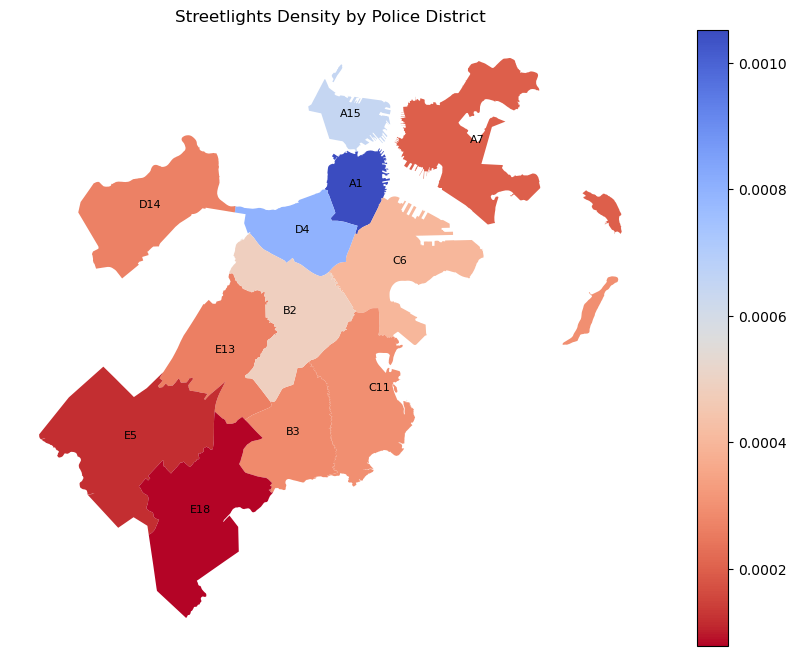

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
police_districts.plot(column='streetlights_density', cmap='coolwarm_r', legend=True, ax=ax)

# Add text labels for district IDs
for idx, row in police_districts.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(s=row['ID'], xy=(centroid.x, centroid.y), color='black', ha='center', fontsize=8)

ax.set_title('Streetlights Density by Police District')
ax.set_axis_off()
plt.show()


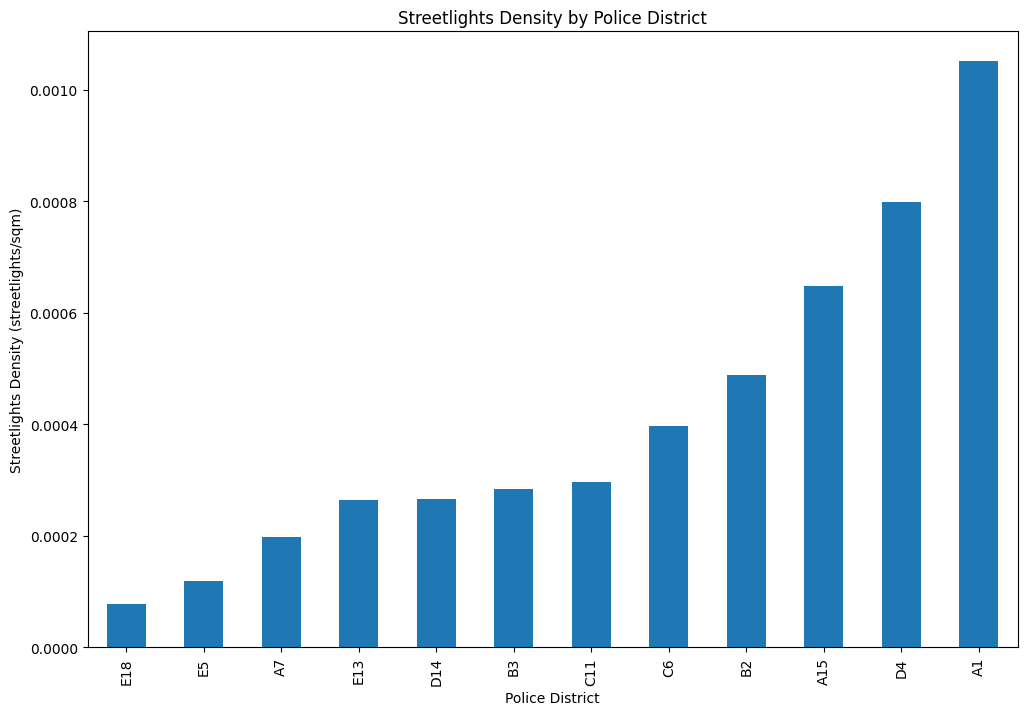

In [ ]:
sorted_gdf = police_districts.sort_values('streetlights_density')

ax = sorted_gdf.plot.bar(x='DISTRICT', y='streetlights_density', figsize=(12, 8), legend=None)

ax.set_xlabel('Police District')
ax.set_ylabel('Streetlights Density (streetlights/sqm)')
ax.set_title('Streetlights Density by Police District')

# Display the plot
plt.show()

## Combine that with shooting incidents

In [35]:
df_2015= pd.read_csv("crime_reports/cir_2015.csv")
df_2016= pd.read_csv("crime_reports/cir_2016.csv")
df_2017= pd.read_csv("crime_reports/cir_2017.csv")
df_2018= pd.read_csv("crime_reports/cir_2018.csv")
df_2019= pd.read_csv("crime_reports/cir_2019.csv")
df_2020= pd.read_csv("crime_reports/cir_2020.csv")
df_2021= pd.read_csv("crime_reports/cir_2021.csv")
df_2022= pd.read_csv("crime_reports/cir_2022.csv")
df_2023= pd.read_csv("crime_reports/cir_2023.csv")

frames = [df_2015,df_2016,df_2017,df_2018,df_2019,df_2020,df_2021,df_2022,df_2023]

df = pd.concat(frames)

In [15]:
all_incidents = df[df['SHOOTING'] == 1]
district_counts = all_incidents.groupby('DISTRICT')['INCIDENT_NUMBER'].count().reset_index(name='incident_count')
police_districts = police_districts.merge(district_counts, on='DISTRICT')
police_districts


,DISTRICT,OBJECTID,ID,BPDGIS_GIS,DISTRICT_,DISTRICT__,ShapeSTAre,ShapeSTLen,geometry,area_sqm,streetlights_count,streetlights_density,incident_count
0,A15,1,A15,A,15,15,3.798284e+07,57556.859964,"MULTIPOLYGON (((-71.07416 42.39051, -71.07415 ...",6.471169e+06,4189,0.000647,28
1,A7,2,A7,A,7,07,1.401151e+08,138468.216080,"MULTIPOLYGON (((-70.99644 42.39557, -70.99644 ...",2.386551e+07,4738,0.000199,69
2,A1,3,A1,A,1,01,4.445582e+07,49080.786370,"POLYGON ((-71.05200 42.36884, -71.05169 42.368...",7.568905e+06,7960,0.001052,48
3,C6,4,C6,C,6,06,1.236928e+08,93915.389108,"POLYGON ((-71.04406 42.35403, -71.04412 42.353...",2.104409e+07,8365,0.000397,117
4,D4,5,D4,D,4,04,7.000553e+07,41040.347429,"POLYGON ((-71.07416 42.35724, -71.07359 42.357...",1.191370e+07,9508,0.000798,170
5,D14,6,D14,D,14,14,1.236253e+08,58025.031627,"POLYGON ((-71.12573 42.36998, -71.12570 42.369...",2.104398e+07,5591,0.000266,62
6,E13,7,E13,E,13,13,1.120474e+08,67548.461582,"POLYGON ((-71.11189 42.33193, -71.11183 42.331...",1.904683e+07,5021,0.000264,187
7,E5,8,E5,E,5,05,1.910675e+08,87149.325855,"POLYGON ((-71.15232 42.29471, -71.15214 42.294...",3.245271e+07,3872,0.000119,72
8,B3,9,B3,B,3,03,9.315860e+07,60465.304581,"POLYGON ((-71.08022 42.30466, -71.08014 42.304...",1.582363e+07,4500,0.000284,983
9,C11,10,C11,C,11,11,1.329335e+08,120593.614180,"MULTIPOLYGON (((-71.05228 42.32144, -71.05216 ...",2.258909e+07,6689,0.000296,690


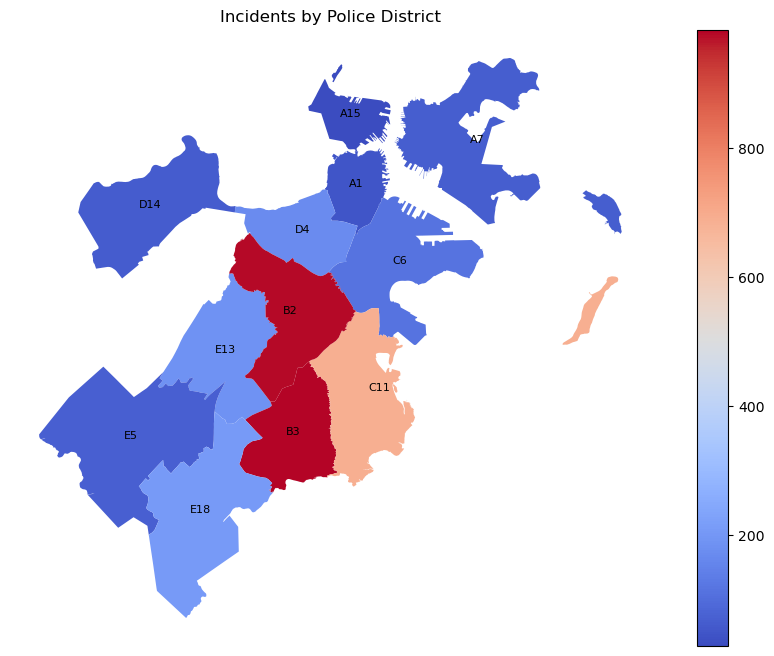

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
police_districts.plot(column='incident_count', cmap='coolwarm', legend=True, ax=ax)

# Add text labels for district IDs
for idx, row in police_districts.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(s=row['ID'], xy=(centroid.x, centroid.y), color='black', ha='center', fontsize=8)

ax.set_title('Incidents by Police District')
ax.set_axis_off()
plt.show()


In [ ]:
shooting_incident = df[df['SHOOTING'] == 1]
shooting_incident = shooting_incident[(shooting_incident["HOUR"] >= 20) | (shooting_incident["HOUR"] <= 6)]
shooting_incident

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
34,192000011,3114,NaN,INVESTIGATE PROPERTY,C11,345,1,2019-01-01 00:30:00,2019,1,Tuesday,0,NaN,LONGFELLOW ST,42.302698,-71.066015,"(42.30269786, -71.06601484)"
72,192000030,1402,NaN,VANDALISM,E18,478,1,2019-01-01 02:04:11,2019,1,Tuesday,2,NaN,MARIPOSA ST,42.268818,-71.106519,"(42.26881757, -71.1065192)"
321,192000312,423,NaN,ASSAULT - AGGRAVATED,B2,262,1,2019-01-02 01:05:00,2019,1,Wednesday,1,NaN,BROOK AVE,42.321815,-71.074058,"(42.32181505, -71.07405838)"
494,192000560,3114,NaN,INVESTIGATE PROPERTY,C11,245,1,2019-01-02 22:15:00,2019,1,Wednesday,22,NaN,SYDNEY ST,42.318105,-71.052580,"(42.31810456, -71.05258008)"
699,192000844,3114,NaN,INVESTIGATE PROPERTY,E13,906,1,2019-01-03 20:10:00,2019,1,Thursday,20,NaN,BICKFORD ST,42.325971,-71.101343,"(42.32597056, -71.10134307)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7881,232011172,3114,NaN,INVESTIGATE PROPERTY,E13,,1,2023-02-10 21:37:00+00,2023,2,Friday,21,NaN,WASHINGTON ST,42.312754,-71.101297,"(42.312753801903895, -71.10129675234704)"
8068,232011405,2662,NaN,BALLISTICS EVIDENCE/FOUND,B2,,1,2023-02-11 20:40:00+00,2023,2,Saturday,20,NaN,DANUBE ST,42.317439,-71.075478,"(42.31743922401911, -71.07547844864659)"
8230,232011907,111,NaN,"MURDER, NON-NEGLIGENT MANSLAUGHTER",B2,,1,2023-02-13 00:00:00+00,2023,2,Monday,0,NaN,DEWEY ST,42.316767,-71.077141,"(42.316766910073476, -71.07714053853037)"
8426,232011954,3114,NaN,INVESTIGATE PROPERTY,B3,,1,2023-02-14 01:54:00+00,2023,2,Tuesday,1,NaN,FAIRMOUNT ST,42.279303,-71.079288,"(42.27930268969712, -71.07928813371267)"


In [ ]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    a = (math.sin(delta_lat / 2) ** 2 +
         math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c


In [ ]:
def count_streetlights_within_10_meters(shooting_incidents_df, streetlights_df):
    MAX_DISTANCE = 0.01  # 10 meters in kilometers
    counts = []

    for _, incident in shooting_incidents_df.iterrows():
        count = 0
        incident_lat = float(incident["Lat"])
        incident_long = float(incident["Long"])

        for _, light in streetlights_df.iterrows():
            light_lat = float(light["Lat"])
            light_long = float(light["Long"])
            distance = haversine_distance(incident_lat, incident_long, light_lat, light_long)

            if distance <= MAX_DISTANCE:
                count += 1
        
        counts.append(count)

    return counts

In [36]:
all_incidents = df[df['SHOOTING'] == 1]

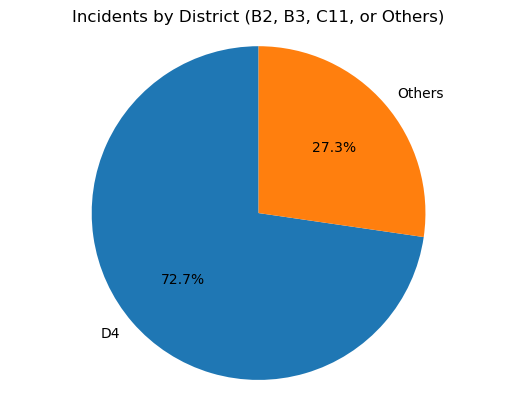

In [37]:
def group_districts(district):
    if district in ['B2', 'B3', 'C11']:
        return 'D4'
    else:
        return 'Others'

all_incidents['district_group'] = all_incidents['DISTRICT'].apply(group_districts)
group_counts = all_incidents['district_group'].value_counts()
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Incidents by District (B2, B3, C11, or Others)')
plt.show()


In [ ]:
shooting_incident["streetlights_within_10_m"] = count_streetlights_within_10_meters(shooting_incident, streetlights)

shooting_incident

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,streetlights_within_10_m
34,192000011,3114,NaN,INVESTIGATE PROPERTY,C11,345,1,2019-01-01 00:30:00,2019,1,Tuesday,0,NaN,LONGFELLOW ST,42.302698,-71.066015,"(42.30269786, -71.06601484)",0
72,192000030,1402,NaN,VANDALISM,E18,478,1,2019-01-01 02:04:11,2019,1,Tuesday,2,NaN,MARIPOSA ST,42.268818,-71.106519,"(42.26881757, -71.1065192)",0
321,192000312,423,NaN,ASSAULT - AGGRAVATED,B2,262,1,2019-01-02 01:05:00,2019,1,Wednesday,1,NaN,BROOK AVE,42.321815,-71.074058,"(42.32181505, -71.07405838)",1
494,192000560,3114,NaN,INVESTIGATE PROPERTY,C11,245,1,2019-01-02 22:15:00,2019,1,Wednesday,22,NaN,SYDNEY ST,42.318105,-71.052580,"(42.31810456, -71.05258008)",0
699,192000844,3114,NaN,INVESTIGATE PROPERTY,E13,906,1,2019-01-03 20:10:00,2019,1,Thursday,20,NaN,BICKFORD ST,42.325971,-71.101343,"(42.32597056, -71.10134307)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7881,232011172,3114,NaN,INVESTIGATE PROPERTY,E13,,1,2023-02-10 21:37:00+00,2023,2,Friday,21,NaN,WASHINGTON ST,42.312754,-71.101297,"(42.312753801903895, -71.10129675234704)",3
8068,232011405,2662,NaN,BALLISTICS EVIDENCE/FOUND,B2,,1,2023-02-11 20:40:00+00,2023,2,Saturday,20,NaN,DANUBE ST,42.317439,-71.075478,"(42.31743922401911, -71.07547844864659)",1
8230,232011907,111,NaN,"MURDER, NON-NEGLIGENT MANSLAUGHTER",B2,,1,2023-02-13 00:00:00+00,2023,2,Monday,0,NaN,DEWEY ST,42.316767,-71.077141,"(42.316766910073476, -71.07714053853037)",1
8426,232011954,3114,NaN,INVESTIGATE PROPERTY,B3,,1,2023-02-14 01:54:00+00,2023,2,Tuesday,1,NaN,FAIRMOUNT ST,42.279303,-71.079288,"(42.27930268969712, -71.07928813371267)",1


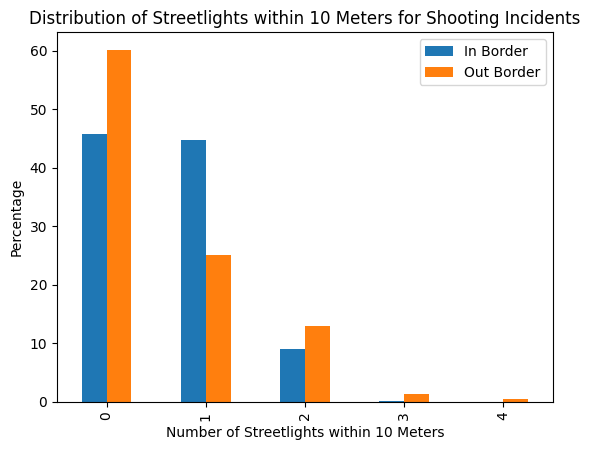

In [ ]:
shooting_in_border = shooting_incident[(shooting_incident["DISTRICT"] == 'B2') | (shooting_incident["DISTRICT"] == 'B3') | (shooting_incident["DISTRICT"] == 'C11')]
shooting_out_border = shooting_incident[(shooting_incident["DISTRICT"] != 'B2') & (shooting_incident["DISTRICT"] != 'B3') & (shooting_incident["DISTRICT"] != 'C11')]

streetlights_distribution_in = shooting_in_border['streetlights_within_10_m'].value_counts(normalize=True).sort_index() * 100
streetlights_distribution_out = shooting_out_border['streetlights_within_10_m'].value_counts(normalize=True).sort_index() * 100

combined_distribution = pd.DataFrame({'In Border': streetlights_distribution_in, 'Out Border': streetlights_distribution_out})

ax = combined_distribution.plot.bar()

ax.set_xlabel('Number of Streetlights within 10 Meters')
ax.set_ylabel('Percentage')
ax.set_title('Distribution of Streetlights within 10 Meters for Shooting Incidents')

plt.show()

Text(0.5, 1.0, 'Number of Streetlights within 10 Meters for Shooting Incidents')

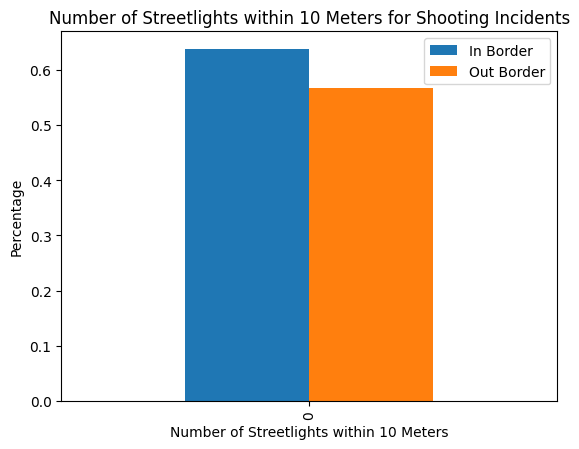

In [ ]:
combined_distribution = pd.DataFrame({'In Border': [shooting_in_border['streetlights_within_10_m'].mean()], 'Out Border': [shooting_out_border['streetlights_within_10_m'].mean()]})

ax = combined_distribution.plot.bar()

ax.set_xlabel('Number of Streetlights within 10 Meters')
ax.set_ylabel('Percentage')
ax.set_title('Number of Streetlights within 10 Meters for Shooting Incidents')

In [ ]:
shooting_incident.to_csv('locationscsv/shooting_incidents.csv', index=False)

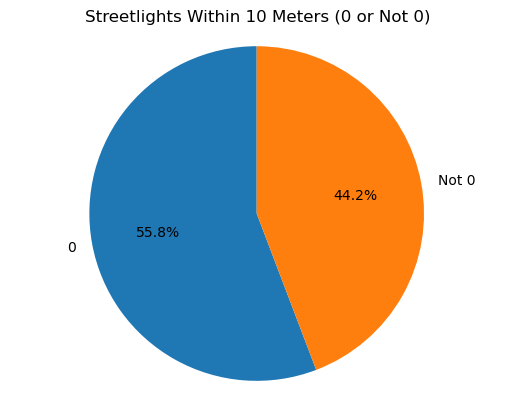

In [31]:
import matplotlib.pyplot as plt
shooting_incident = pd.read_csv('locationscsv/shooting_incidents.csv')
filtered_df = shooting_incident[shooting_incident['streetlights_within_10_m'].isin([0, 1])]
value_counts = filtered_df['streetlights_within_10_m'].value_counts(normalize=True)
plt.pie(value_counts, labels=['0', 'Not 0'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Streetlights Within 10 Meters (0 or Not 0)')
plt.show()
